In [2]:
!git clone https://github.com/nianticlabs/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180 (from 1)
Receiving objects: 100% (180/180), 10.27 MiB | 13.58 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [4]:
# if you want to use whole dataset just run this cell (be careful, it weights 175gb)
# we used only these two lines from the kitti_archives_to_download:
# https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
# https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0027/2011_10_03_drive_0027_sync.zip

!wget -i /content/monodepth2/splits/kitti_archives_to_download.txt -P kitti_data/

--2024-12-27 07:44:42--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.136.2, 52.219.171.13, 52.219.171.169, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.136.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘kitti_data/2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2024-12-27 07:44:42 (168 MB/s) - ‘kitti_data/2011_10_03_calib.zip’ saved [4075/4075]

--2024-12-27 07:44:42--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0027/2011_10_03_drive_0027_sync.zip
Reusing existing connection to s3.eu-central-1.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 18349607637 (17G) [application/zip]
Saving to: ‘kitti_data/2011_10_03_drive_0027_sync.zip’

2011_10_03_drive_00 100%[

In [8]:
%cd /content/kitti_data
!ls
!unzip "*.zip"
!cd ..

Streaming output truncated to the last 5000 lines.
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000000426.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000000479.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000003620.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000000531.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000002874.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000000614.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000001645.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000001458.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000001575.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000003998.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000001573.png  
 extracting: 2011_10_03/2011_10_03_drive_0027_s

In [9]:
!find /content/kitti_data -name '*.png' | parallel 'convert -quality 92 -sampling-factor 2x2,1x1,1x1 {.}.png {.}.jpg && rm {}'

In [10]:
%cd /content/monodepth2

/content/monodepth2


### Loading model

In [11]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

In [12]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

-> Downloading pretrained model to models/mono_640x192.zip
   Unzipping model...
   Model unzipped to models/mono_640x192


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-12-baf02cc877d3>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True

### Load and preprocess image

In [13]:
image_path = "/content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_01/data/0000000000.png"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

### Predict and save predictions

In [14]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

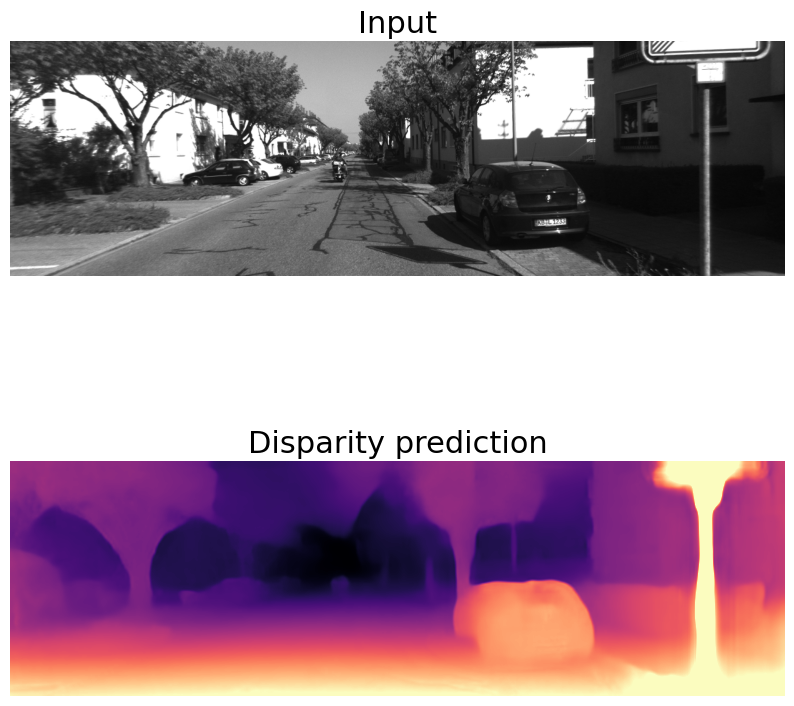

In [15]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

### Predict for a folder

In [19]:
!python test_simple.py --image_path '/content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data' --model_name 'mono_640x192' --ext 'png'

Streaming output truncated to the last 5000 lines.
   - /content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000000027_disp.npy
   Processed 2879 of 4544 images - saved predictions to:
   - /content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000003126_disp.jpeg
   - /content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000003126_disp.npy
   Processed 2880 of 4544 images - saved predictions to:
   - /content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000000499_disp.jpeg
   - /content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000000499_disp.npy
   Processed 2881 of 4544 images - saved predictions to:
   - /content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000004185_disp.jpeg
   - /content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000004185_disp.npy
   Processed 2882 of 4544 images - saved predictions to:
   - /content/kitti_data/2011_10_03/201

In [32]:
image_pairs = [
    '/content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000000000',
    '/content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000000010',
    '/content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000000020',
    '/content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000000030',
    '/content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data/0000000040'
]

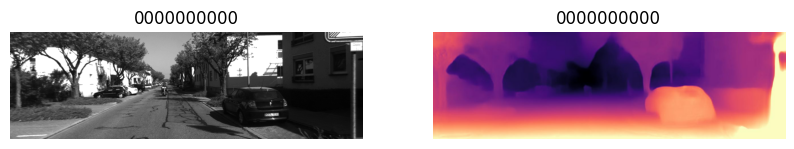

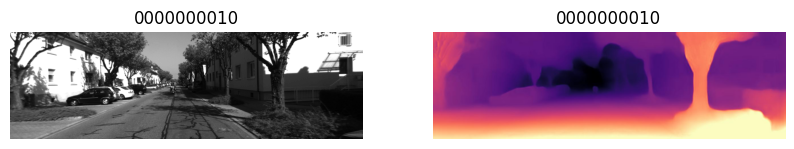

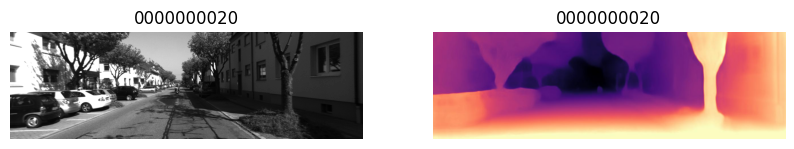

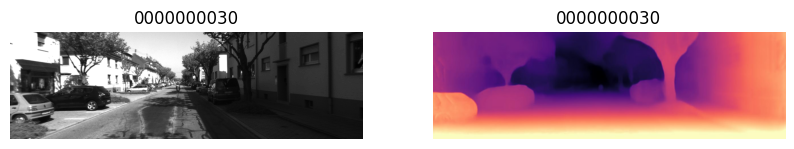

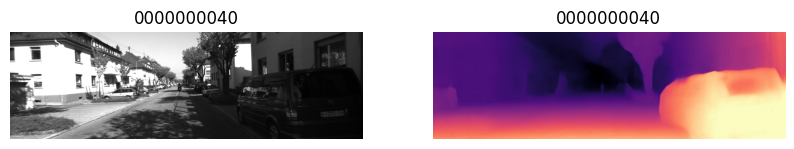

In [35]:
import matplotlib.image as mpimg

for name in image_pairs:
    png_file = name + ".png"
    jpeg_file = name + "_disp.jpeg"

    png_image = mpimg.imread(png_file)
    jpeg_image = mpimg.imread(jpeg_file)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(png_image, cmap='gray')
    axes[0].set_title(f"{name[name.rfind('/') + 1:]}")
    axes[0].axis('off')

    axes[1].imshow(jpeg_image)
    axes[1].set_title(f"{name[name.rfind('/') + 1:]}")
    axes[1].axis('off')
    plt.show()

### Stereo-trained model

In [ ]:
!python test_simple.py --image_path '/content/kitti_data/2011_10_03/2011_10_03_drive_0027_sync/image_00/data' --model_name 'mono+stereo_640x192' --ext 'png' --pred_metric_depth

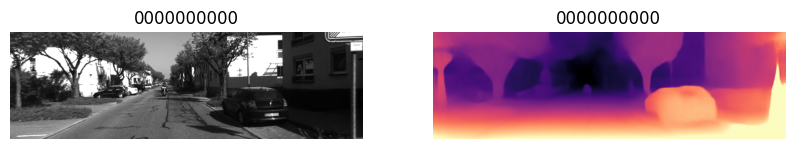

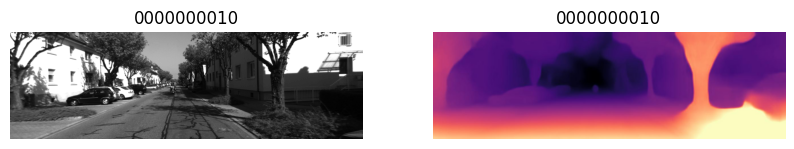

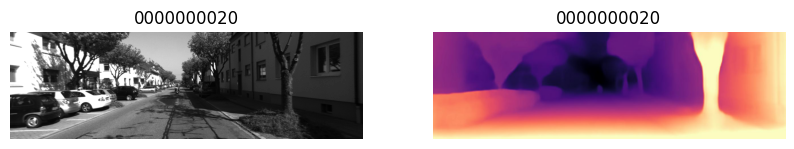

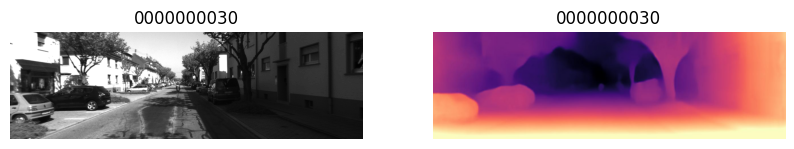

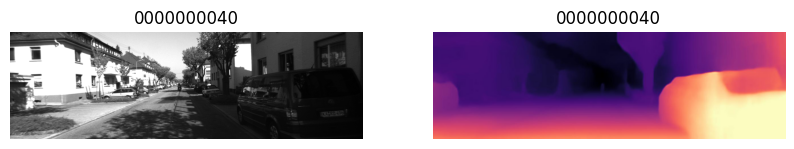

In [37]:
import matplotlib.image as mpimg

for name in image_pairs:
    png_file = name + ".png"
    jpeg_file = name + "_disp.jpeg"

    png_image = mpimg.imread(png_file)
    jpeg_image = mpimg.imread(jpeg_file)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(png_image, cmap='gray')
    axes[0].set_title(f"{name[name.rfind('/') + 1:]}")
    axes[0].axis('off')

    axes[1].imshow(jpeg_image)
    axes[1].set_title(f"{name[name.rfind('/') + 1:]}")
    axes[1].axis('off')
    plt.show()